# Chargmeent des différentes librairies 


Simulation d'une source de Cs-137 dans un détecteur CdTe avec deux murs en plomb


In [11]:
# -*- coding: utf-8 -*-

"""
Simulation d'une source de Cs-137 dans un détecteur CdTe
Ce script crée une simulation OpenMC d'une source de Cs-137 dans un détecteur CdTe, avec un mur en béton et une région d'air.
Il inclut la configuration des matériaux, des surfaces, des cellules, de la source et des tallies.
"""

import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, LEAD_MATERIAL
from src.utils.pre_processing.pre_processing import remove_previous_results, parallelepiped, plot_geometry, mesh_tally_xy
from src.utils.post_preocessing.post_processing import load_mesh_tally

os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

materials = openmc.Materials([CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, LEAD_MATERIAL])


# Définitions des surfaces 

In [12]:
# Surfaces
sphere = openmc.Sphere(r=1.0, surface_id=1)
# Create a 4x4 lattice of spheres along the y-z plane, centered at x=30
detector_spheres = []
lattice_size = 5
radius_detector = 3.0  # radius of each sphere
spacing = 2 * radius_detector + 1.0  # diameter + gap, adjust as needed
center_x = 30.0
start_y = -((lattice_size - 1) / 2) * spacing
start_z = -((lattice_size - 1) / 2) * spacing

for i in range(lattice_size):
    for j in range(lattice_size):
        y = start_y + i * spacing
        z = start_z + j * spacing
        sph = openmc.Sphere(x0=center_x, y0=y, z0=z, r=radius_detector)
        detector_spheres.append(sph)

# The detector region is the union of all these spheres (as negative halfspaces)
detector = -detector_spheres[0]
for sph in detector_spheres[1:]:
    detector |= -sph

outer_boundary = openmc.Sphere(r=200.0, surface_id=8, boundary_type='vacuum')  # Limite du monde


# Create lead wall using parallelepiped
wall_region_1 = parallelepiped(-40, -20, -50, 50, -50, 50, surface_id_start=10)

# another lead wall 
wall_region_2 = parallelepiped(-20, 50, -50, -30, -50, 50, surface_id_start=20)

outer_boundary_cell = -outer_boundary 

void_region = outer_boundary_cell & ~(detector) & ~wall_region_1 & ~wall_region_2



/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=8.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=11.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=12.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-package

# Définition des cellules 

In [13]:
# Cells
source_cell = openmc.Cell(name="source_cell")
source_cell.fill = CS137_MATERIAL
source_cell.region = -sphere

detector_cells = []
for idx, sph in enumerate(detector_spheres):
    cell = openmc.Cell(name=f"detector_sphere_{idx}", fill=CDTE_MATERIAL, region=-sph)
    detector_cells.append(cell)

wall_cell_1 = openmc.Cell(name="lead wall east", fill=LEAD_MATERIAL, region=wall_region_1)
wall_cell_2 = openmc.Cell(name="lead wall south", fill=LEAD_MATERIAL, region=wall_region_2)

# Air cell (everything else inside the outer boundary, minus source, detector, and wall)
void_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=void_region)

universe = openmc.Universe(cells=[source_cell, wall_cell_1, wall_cell_2, void_cell])
universe.add_cells(detector_cells)
geometry = openmc.Geometry(universe)


In [14]:
# Création de la source
source = openmc.Source()
source.space = openmc.stats.Point((0, 0, 0))
source.energy = openmc.stats.Discrete([661_700], [1.0])  # Énergie du photon de 662 keV pour Cs137
source.angle = openmc.stats.Isotropic() 
source.particle = "photon"
source.strength = 1e9  # Activité en Bq

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


# Définitions des tallys

In [15]:
# Mesh tally de flux 
mesh_tally = mesh_tally_xy(particule_type="photon", upper_right=(60, 60), lower_left=(-60, -60), z_thickness=4)
tallies = openmc.Tallies([mesh_tally])

In [ ]:
sphere_tallies = []
for idx, cell in enumerate(detector_cells):
    tally = openmc.Tally(name=f"flux_sphere_{idx}")
    tally.filters = [openmc.CellFilter(cell), openmc.ParticleFilter(['photon'])]
    tally.scores = ['flux']
    sphere_tallies.append(tally)

for tally in sphere_tallies:
    tallies.append(tally)


In [ ]:
sphere_tallies_heat = []
energy_bins = np.linspace(1e-3, 1.0e6, 500)  # de 1 keV à 1 MeV en 500 bins
for idx, cell in enumerate(detector_cells):
    energy_filter = openmc.EnergyFilter(energy_bins)
    tally = openmc.Tally(name=f"pulse-height_{idx}")
    tally.filters = [openmc.CellFilter(cell), energy_filter]
    tally.scores = ['pulse-height']
    sphere_tallies_heat.append(tally)
    
for tally in sphere_tallies_heat:
    tallies.append(tally)


In [18]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 20
settings.batches = batches_number
settings.particles = 10**7
settings.source = source
settings.photon_transport = True 
settings.run_mode = "fixed source"
settings.verbose = True


In [19]:

# Export des fichiers nécessaires pour la simulation
materials.export_to_xml()
geometry.export_to_xml()
settings.export_to_xml()
tallies.export_to_xml()


/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=104.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=105.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=107.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=155.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=109.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packa

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

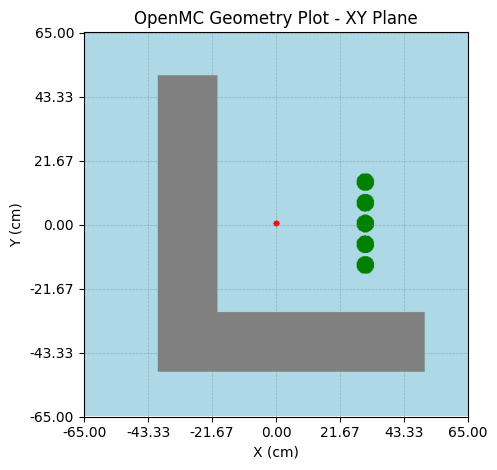

In [20]:
plot_geometry(materials=materials, origin=(0,0,0),width=130, height=130)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

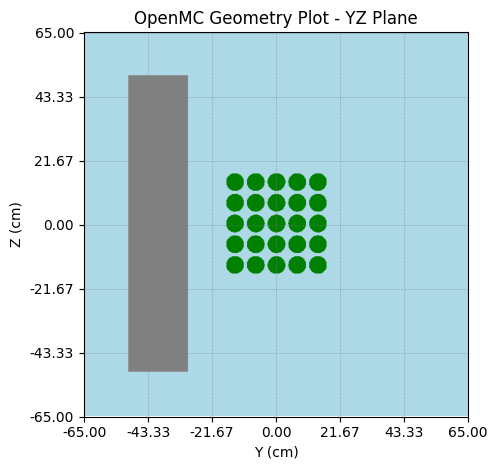

In [21]:
plot_geometry(materials=materials, plane="yz", origin=(30,0,0) ,width=130, height=130)

In [22]:
remove_previous_results(batches_number)
os.environ["OMP_NUM_THREADS"] = "4"
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [23]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")

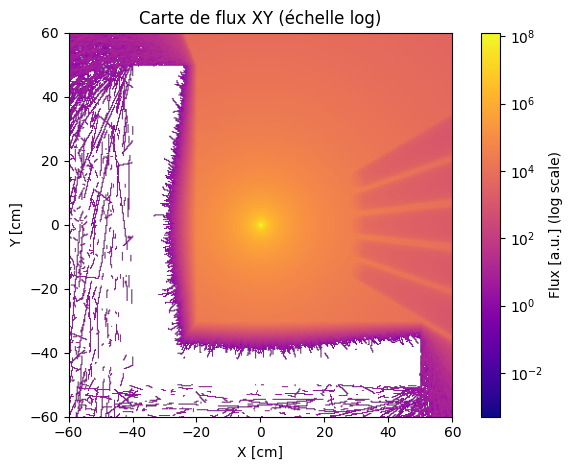

In [24]:
load_mesh_tally(statepoint_file=sp, cwd= CWD, name_mesh_tally="flux_mesh", 
                upper_right=[60.0, 60.0], lower_left=[-60.0, -60.0],
                zoom_x=(-60.0, 60.0), zoom_y=(-60.0, 60.0))

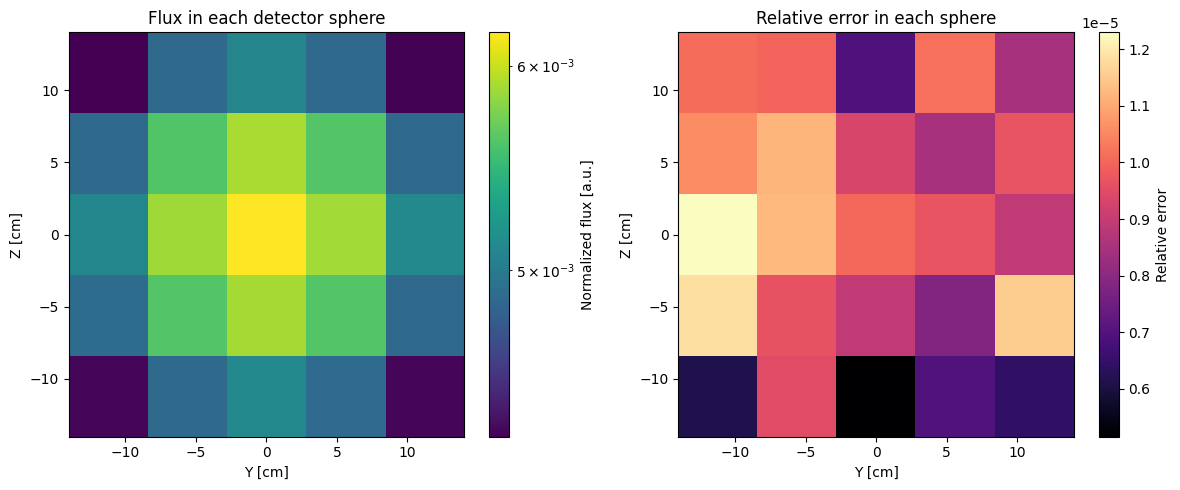

In [25]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
sphere_fluxes = []
sphere_errors = []
for idx in range(len(detector_cells)):
    tally = sp.get_tally(name=f"flux_sphere_{idx}")
    flux = tally.mean.flatten()[0] / source.strength
    error = tally.std_dev.flatten()[0] / source.strength
    sphere_fluxes.append(flux)
    sphere_errors.append(error)

# Recréer la grille spatiale des sphères
flux_grid = np.array(sphere_fluxes).reshape((lattice_size, lattice_size))
error_grid = np.array(sphere_errors).reshape((lattice_size, lattice_size))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot flux
im0 = axs[0].imshow(
    flux_grid,
    origin='lower',
    cmap='viridis',
    norm=LogNorm(vmin=np.min(flux_grid[flux_grid != 0]), vmax=flux_grid.max()),
    interpolation='nearest',
    aspect='auto',
    extent=[start_y, start_y + (lattice_size-1)*spacing,
            start_z, start_z + (lattice_size-1)*spacing]
)
fig.colorbar(im0, ax=axs[0], label='Normalized flux [a.u.]')
axs[0].set_title('Flux in each detector sphere')
axs[0].set_xlabel('Y [cm]')
axs[0].set_ylabel('Z [cm]')

# Plot error
im1 = axs[1].imshow(
    error_grid,
    origin='lower',
    cmap='magma',
    interpolation='nearest',
    aspect='auto',
    extent=[start_y, start_y + (lattice_size-1)*spacing,
            start_z, start_z + (lattice_size-1)*spacing]
)
fig.colorbar(im1, ax=axs[1], label='Relative error')
axs[1].set_title('Relative error in each sphere')
axs[1].set_xlabel('Y [cm]')
axs[1].set_ylabel('Z [cm]')

plt.tight_layout()
plt.show()

In [61]:
sphere_fluxes = np.array(sphere_fluxes)
# Sauvegarder les résultats dans un fichier JSON
results = {
    "sphere_fluxes": sphere_fluxes.tolist(),
    "sphere_errors": sphere_errors,
    "lattice_size": lattice_size,
    "spacing": spacing,
    "start_y": start_y,
    "start_z": start_z
}
results_file = CWD / "results.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

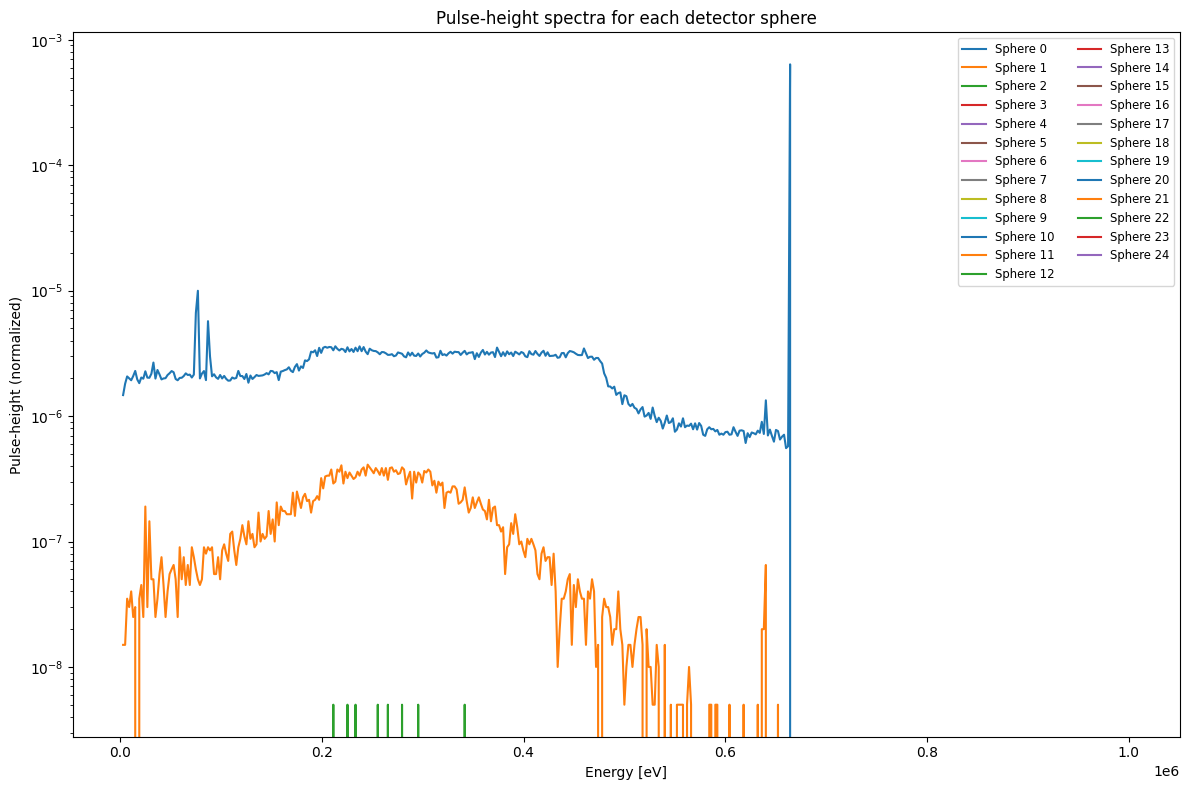

In [28]:
energy_bins = np.linspace(1e-3, 1.0e6, 500)  # same as in tally definition
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])

plt.figure(figsize=(12, 8))
for idx in range(len(detector_cells)):
    tally = sp.get_tally(name=f"pulse-height_{idx}")
    pulse_height_values = tally.get_values(scores=['pulse-height']).flatten()/source.strength  # normalize by source strength

    # spectrum = tally.mean.flatten() / source.strength  # normalize by source strength
    plt.semilogy(energy_bin_centers, pulse_height_values, label=f'Sphere {idx}')

plt.xlabel('Energy [eV]')
plt.ylabel('Pulse-height (normalized)')
plt.title('Pulse-height spectra for each detector sphere')
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.tight_layout()
plt.show()